In [2]:
#!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.9 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 6.9 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Unin

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import math
from d2l import torch as d2l

In [2]:
def masked_softmax(X, valid_lens):
   # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [3]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [5]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

In [7]:
print("Queries:", queries)
print("Keys:", keys)
print("Values:", values)

Queries: tensor([[[-0.7725,  0.8566]],

        [[-1.2345, -2.3322]]])
Keys: tensor([[[-0.5854,  1.5926],
         [-2.5552, -0.8823],
         [ 0.1449,  1.9322],
         [-0.8059, -0.9449],
         [-0.2127, -0.8766],
         [ 0.1137, -0.5516],
         [-0.7507,  2.1131],
         [ 0.8827,  2.1769],
         [-0.2551, -0.6067],
         [-0.1412, -0.6011]],

        [[ 1.3617,  0.7616],
         [-0.7444, -0.1198],
         [-0.1196, -0.0830],
         [ 0.8533, -0.7382],
         [ 0.7525, -1.3430],
         [ 0.6258, -0.4628],
         [-0.8532,  0.7611],
         [-1.0895,  0.4683],
         [ 0.7638, -0.3492],
         [-0.3596,  0.4026]]])
Values: tensor([[[-0.4008,  1.0356,  0.9094, -0.9309],
         [ 1.6710, -3.4506, -0.9259, -1.5673],
         [-1.6039,  0.7193,  0.0724,  0.8813],
         [ 1.4558,  0.3262,  1.0607,  0.1316],
         [-0.4522, -0.3081,  0.4397,  0.7929],
         [-0.9016, -0.0722,  0.9271, -0.2390],
         [-0.1767,  1.3277, -0.3513,  0.0673],
  

In [15]:
attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

In [16]:
print(attention(queries, keys, values, valid_lens))

tensor([[[ 0.4192, -0.7400,  0.1831, -1.1828]],

        [[ 0.8565,  0.1857, -1.1634,  0.2030]]])


In [18]:
print(attention.attention_weights.reshape((1, 1, 2, 10)))

tensor([[[[0.6042, 0.3958, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.0077, 0.2067, 0.1128, 0.1421, 0.4207, 0.1101, 0.0000, 0.0000,
           0.0000, 0.0000]]]])


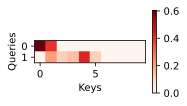

In [10]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [14]:
print(attention.attention_weights)

tensor([[[0.6042, 0.3958, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0077, 0.2067, 0.1128, 0.1421, 0.4207, 0.1101, 0.0000, 0.0000,
          0.0000, 0.0000]]])


## Multi Head Attention

In [21]:
class MultiHeadAttention(d2l.Module):
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

In [22]:
@d2l.add_to_class(MultiHeadAttention)
def transpose_qkv(self, X):
    # Shape of input X: (batch_size, no. of queries or key-value pairs,
    # num_hiddens). Shape of output X: (batch_size, no. of queries or
    # key-value pairs, num_heads, num_hiddens / num_heads)
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    # Shape of output X: (batch_size, num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    X = X.permute(0, 2, 1, 3)
    # Shape of output: (batch_size * num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

@d2l.add_to_class(MultiHeadAttention)
def transpose_output(self, X):
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [23]:
num_hiddens, num_heads = 10, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([6, 6])

X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))

# Create varied input tensors with random values to see different attention behaviors
X = torch.randn((batch_size, num_queries, num_hiddens))  # Random queries
Y = torch.randn((batch_size, num_kvpairs, num_hiddens))  # Random keys and values


d2l.check_shape(attention(X, Y, Y, valid_lens),
                (batch_size, num_queries, num_hiddens))

print("Attention weights across heads:")
attention_weights = attention.attention.attention_weights  # Access the attention weights
for head in range(num_heads):
    print(f"Head {head + 1}:")
    print(attention_weights[head].detach().numpy())  # Detaching for safe printing

Attention weights across heads:
Head 1:
[[0.1628998  0.15774195 0.137724   0.15195647 0.1971368  0.19254097]
 [0.13381802 0.12170057 0.0855118  0.14276096 0.2127471  0.3034615 ]
 [0.17576502 0.18396349 0.21699381 0.16620146 0.14196856 0.11510777]
 [0.17756099 0.20234482 0.3235831  0.1480331  0.09704854 0.05142946]]
Head 2:
[[0.19572099 0.16582896 0.19105834 0.16283102 0.15589987 0.12866083]
 [0.22287889 0.15449342 0.18434706 0.18014774 0.13669966 0.1214332 ]
 [0.18051273 0.152504   0.14689827 0.19375636 0.14594258 0.18038611]
 [0.22138168 0.16383073 0.21631943 0.15390345 0.14613532 0.09842942]]
Head 3:
[[0.13970765 0.16120376 0.17620635 0.18109562 0.1681077  0.17367893]
 [0.3213205  0.07937257 0.15059781 0.12301851 0.12819023 0.19750044]
 [0.11421293 0.22752899 0.16170329 0.17845765 0.17693616 0.14116095]
 [0.051206   0.35276723 0.13935943 0.18388575 0.17729512 0.09548644]]
Head 4:
[[0.2054511  0.15118624 0.14705545 0.15894496 0.14347006 0.19389214]
 [0.05745755 0.18820448 0.22400548 0

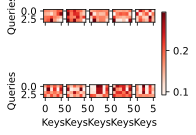

In [24]:
d2l.show_heatmaps(attention_weights.reshape(2,5,4,6),
                  xlabel='Keys', ylabel='Queries')

## Positional Encoding

In [25]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

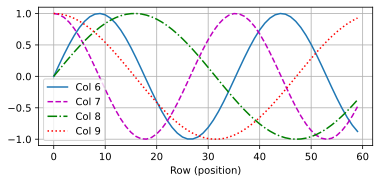

In [26]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

## Encoder Decoder

In [27]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [28]:
ffn = PositionWiseFFN(4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.0043, -0.6239, -0.1296,  0.4768,  0.2271,  0.0036,  0.0264, -0.7130],
        [-0.0043, -0.6239, -0.1296,  0.4768,  0.2271,  0.0036,  0.0264, -0.7130],
        [-0.0043, -0.6239, -0.1296,  0.4768,  0.2271,  0.0036,  0.0264, -0.7130]],
       grad_fn=<SelectBackward0>)

In [30]:
class AddNorm(nn.Module):
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [31]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [ ]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
encoder_blk.eval()
d2l.check_shape(encoder_blk(X, valid_lens), X.shape)

In [38]:
import torch
import torch.nn as nn

# Define a simple tokenizer (map words to indices)
word_to_index = {
    'villasenor': 0,
    'nailed': 1,
    'a': 2,
    '33-yard': 3,
    'field-goal': 4,
}

# Tokenize the input sentence: "the cat sat on the mat"
sentence = ['villasenor', 'nailed', 'a', '33-yard', 'field-goal']
tokenized_input = torch.tensor([word_to_index[word] for word in sentence])

# Random embedding for each word (5 words in the vocabulary, embedding size of 4)
embedding = nn.Embedding(num_embeddings=len(word_to_index), embedding_dim=4)

# Create the input tensor (sequence_length, batch_size, num_hiddens)
X = embedding(tokenized_input).unsqueeze(1)  # Add batch dimension (batch_size = 1)

# Assuming TransformerEncoderBlock is already defined, instantiate it:
encoder_block = TransformerEncoderBlock(num_hiddens=4, ffn_num_hiddens=8, num_heads=2, dropout=0.1)

# Call the encoder block with this input
encoded_output = encoder_block(X, valid_lens=None)

# Print the encoded output
print("Encoded Output:")
print(encoded_output)


Encoded Output:
tensor([[[-1.0638, -0.2672,  1.6430, -0.3121]],

        [[ 1.3652,  0.4013, -1.3387, -0.4278]],

        [[-1.6143, -0.0529,  0.8608,  0.8063]],

        [[-1.0940, -0.8722,  1.2172,  0.7489]],

        [[-1.1584, -0.2127,  1.6001, -0.2291]]],
       grad_fn=<NativeLayerNormBackward0>)


In [33]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [34]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [35]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

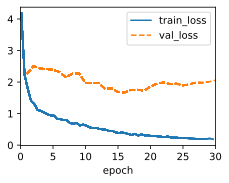

In [41]:
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.001)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [42]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000
